In [1]:
import cvxpy as cvx
import ipopt
import numpy as np
import matplotlib.pyplot as plt
plt.rc("text", usetex=True)
%matplotlib inline

## DCP with CVXPy

Model problem is [compressed sensing](https://www.raeng.org.uk/publications/other/candes-presentation-frontiers-of-engineering)

\begin{align*}
& \min_x \|x\|_1\\
\text{s.t. } & Ax = b,
\end{align*}
где $A \in \mathbb{R}^{m \times n}$ и $n \gg m$

### Data generation

In [2]:
n = 1000
m = 10
x_true = np.random.randn(n)
x_true[np.abs(x_true) > 0.05] = 0
print("Num of nnz in x = {}".format(np.sum(x_true != 0)))
A = np.random.randn(m, n)
b = A.dot(x_true)

Num of nnz in x = 45


### [CVXPy](http://www.cvxpy.org/index.html) 

In [3]:
x = cvx.Variable(n)
objective = cvx.norm1(x)
constr = [A*x == b]
problem = cvx.Problem(cvx.Minimize(objective), constr) 
problem.solve(verbose=True, max_iters=3000, solver="SCS")

----------------------------------------------------------------------------
	SCS v1.2.6 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012-2016
----------------------------------------------------------------------------
Lin-sys: sparse-indirect, nnz in A = 14000, CG tol ~ 1/iter^(2.00)
eps = 1.00e-04, alpha = 1.50, max_iters = 3000, normalize = 1, scale = 1.00
Variables n = 2000, constraints m = 2010
Cones:	primal zero / dual free vars: 10
	linear vars: 2000
Setup time: 1.39e-03s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0|      inf       inf       nan      -inf       inf       inf  2.79e-03 
   100| 1.34e-03  1.21e-02  6.42e-04  2.38e-01  2.39e-01  5.98e-17  3.10e-02 
   200| 9.11e-04  8.86e-03  2.87e-04  2.31e-01  2.31e-01  3.54e-17  5.86e-02 
   300| 5.97e-04  6.21e

0.22172806576509355

### Check solution

In [4]:
tol= 1e-4
print(np.linalg.norm(A.dot(x.value) - b))
print(np.linalg.norm(A[:, np.abs(x.value) > tol].dot(x.value[np.abs(x.value) > tol]) - b))
print(np.linalg.norm(x_true - x.value))
print("Num nnz = {}".format(np.sum(np.abs(x.value) > tol)))

0.00012982996616774656
0.0002653832780144073
0.20686794882265463
Num nnz = 12


(array([-0.06, -0.04, -0.02,  0.  ,  0.02,  0.04,  0.06,  0.08]),
 <a list of 8 Text yticklabel objects>)

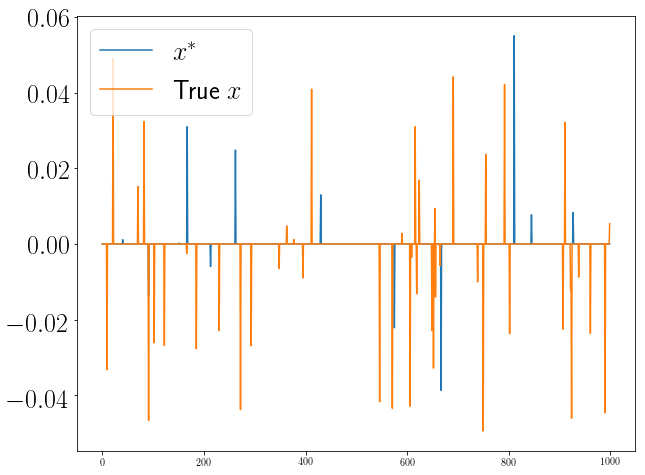

In [5]:
plt.figure(figsize=(10, 8))
plt.plot(x.value, label=r"$x^*$")
plt.plot(x_true, label=r"True $x$")
plt.legend(fontsize=26)
plt.yticks(fontsize=26)

(array([-200.,    0.,  200.,  400.,  600.,  800., 1000., 1200.]),
 <a list of 8 Text xticklabel objects>)

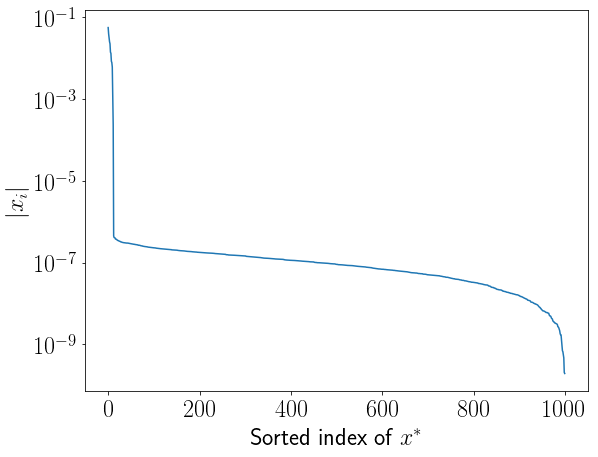

In [6]:
plt.figure(figsize=(9, 7))
plt.semilogy(np.sort(np.abs(x.value))[::-1])
plt.ylabel("$|x_i|$", fontsize=24)
plt.yticks(fontsize=24)
plt.xlabel(r"Sorted index of $x^*$", fontsize=24)
plt.xticks(fontsize=24)

### Check DCP

In [7]:
# Non-affine equality constraint
y = cvx.Variable(1)
obj = cvx.Minimize(cvx.power(y, 3))
problem = cvx.Problem(obj, [cvx.power(y-3, 2) == 0])
problem.solve(verbose=True)
print(y.value)

DCPError: Problem does not follow DCP rules. Specifically:
The following constraints are not DCP:
power(var53 + -3.0, 2) == 0.0 , because the following subexpressions are not:
|--  power(var53 + -3.0, 2) == 0.0

In [ ]:
# Non-convex objective function 
y = cvx.Variable(2)
obj = cvx.Minimize(y[0]**2 - y[1]**2)
problem = cvx.Problem(obj)
problem.solve(verbose=True)

## General purpose IPOPT

#### Smooth problem similar to the problem in part 1

\begin{align*}
& \min_x \|x\|^2_2\\
\text{s.t. } & Ax = b,
\end{align*}
где $A \in \mathbb{R}^{m \times n}$ и $n \gg m$

In [8]:
f = lambda x: np.linalg.norm(x, 2)**2
constr = {"fun": lambda x: A.dot(x) - b, 
          "jac": lambda x: A,
          "type": "eq"}
res = ipopt.minimize_ipopt(f, jac=lambda x: 2 * x, x0=np.zeros(n), constraints=constr)

In [9]:
print(np.linalg.norm(A.dot(res.info["x"]) - b))
res.info["status_msg"]

5.652963170076841e-16


b'Algorithm terminated successfully at a locally optimal point, satisfying the convergence tolerances (can be specified by options).'

#### Non-smooth problem from part 1

\begin{align*}
& \min_x \|x\|_1\\
\text{s.t. } & Ax = b,
\end{align*}
где $A \in \mathbb{R}^{m \times n}$ и $n \gg m$

In [10]:
f = lambda x: np.linalg.norm(x, 1)
constr = {"fun": lambda x: A.dot(x) - b, 
          "jac": lambda x: A,
          "type": "eq"}
res = ipopt.minimize_ipopt(f, jac=lambda x: np.sign(x), x0=np.zeros(n), constraints=constr)

In [11]:
print(np.linalg.norm(A.dot(res.info["x"]) - b))
res.info["status_msg"]

5.887846720064156e-17


b"Restoration phase failed, algorithm doesn't know how to proceed."